In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from concurrent import futures
import numpy as np
from scipy.stats import gaussian_kde
import pandas_datareader.data as web
data_dir = "./data/most_attractive_stocks"
os.makedirs(data_dir, exist_ok=True)

### List of SP500 companies

In [2]:
tables = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_df = tables[0]
second_table = tables[1]
print(sp500_df.shape)
# rename symbol to escape symbol error
sp500_df["Symbol"] = sp500_df["Symbol"].map(lambda x: x.replace(".", "-"))  
sp500_df.to_csv("./data/SP500.csv", index=False)
sp500_df = pd.read_csv("./data/SP500.csv")
print(sp500_df.shape)
sp500_tickers = list(sp500_df["Symbol"])
sp500_df.head()

(503, 9)
(503, 9)


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


In [6]:
def download_stock(stock):
    try:
        print(stock)
        stock_df = web.DataReader(stock, 'yahoo', start_time, end_time)
        stock_df['Name'] = stock
        output_name = f"{data_dir}/{stock}.csv"
        stock_df.to_csv(output_name)
    except BaseException:
        bad_names.append(stock)
        print('bad: %s' % (stock))
""" set the download window """
start_time = dt.datetime(1900, 1, 1)
end_time = dt.datetime(2022, 6, 15)
bad_names = []  # to keep track of failed queries
#set the maximum thread number
max_workers = 20
now = dt.datetime.now()
path_failed_queries = f'{data_dir}/failed_queries.txt'
if os.path.exists(path_failed_queries):
    with open(path_failed_queries) as f:
        failed_queries = f.read().split("\n")[:-1]
        sp500_tickers_ = failed_queries
else:
    sp500_tickers_ = sp500_tickers
print("number of stocks to download:", len(sp500_tickers_))
# in case a smaller number of stocks than threads was passed in
workers = min(max_workers, len(sp500_tickers_))
with futures.ThreadPoolExecutor(workers) as executor:
    res = executor.map(download_stock, sp500_tickers_)
""" Save failed queries to a text file to retry """
if len(bad_names) > 0:
    with open(path_failed_queries, 'w') as outfile:
        for name in bad_names:
            outfile.write(name + '\n')
finish_time = dt.datetime.now()
duration = finish_time - now
minutes, seconds = divmod(duration.seconds, 60)
print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')
print(f"{len(bad_names)} stocks failed: ", bad_names)

number of stocks to download: 503
MMM
AOS
ABT
ABBV
ABMD
ACN
ATVI
ADM
ADBE
ADP
AAP
AES
AFL
A
APD
AKAM
ALK
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AMD
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
ADI
ANSS
ANTM
AON
APA
AAPL
AMAT
APTV
ANET
AJG
AIZ
T
ATO
ADSK
AZO
AVB
AVY
BKR
BALL
BAC
BBWI
BAX
BDX
WRB
BRK-B
BBY
BIO
TECH
BIIB
BLK
BK
BA
BKNG
BWA
BXP
BSX
BMY
AVGO
BR
BRO
BF-B
CHRW
CDNS
CZR
CPT
CPB
COF
CAH
KMX
CCL
CARR
CTLT
CAT
CBOE
CBRE
CDW
CE
CNC
CNP
CDAY
CF
CRL
SCHW
CHTR
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
CCFG

CTXS
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
COP
ED
STZ
CEG
COO
CPRT
GLW
CTVA
COST
CTRA
CCI
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DAL
XRAY
DVN
DXCM
FANG
DLR
DFS
DISH
DIS
DG
DLTR
D
DPZ
DOV
DOW
DTE
DUK
DRE
DD
DXC
EMN
ETN
EBAY
ECL
EIX
EW
EA
LLY
EMR
ENPH
ETR
EOG
EPAM
EFX
EQIX
EQR
ESS
EL
ETSY
RE
EVRG
ES
EXC
EXPE
EXPD
EXR
XOM
FFIV
FDS
FAST
FRT
FDX
FITB
FRC
FE
FIS
FISV
FLT
FMC
F
FTNT
FTV
FBHS
FOXA
FOX
BEN
FCX
GRMN
IT
GE
GNRC
GD
GIS
GM
GPC
GILD
GL
GPN
GS
HAL
HIG
HAS
HCA
PEAK
HSIC
HSY
HES
HPE


In [3]:
historical_stock_data_files = glob.glob(f"{data_dir}/*.csv")
highest_day_list = []
for files in historical_stock_data_files:
    price = pd.read_csv(files, index_col="Date", parse_dates=True)
    ticker = os.path.splitext(os.path.basename(files))[0]
    price_close = price[["Close"]]
    highest_day = price_close.idxmax()[0]
    highest_price = price_close.max()[0]
    highest_day_list.append(
        pd.DataFrame({"highest_day": [highest_day], "ticker": [ticker], "highest_price": highest_price}))
df = pd.concat(highest_day_list).reset_index(drop=True)
print(df.shape)
df.head()

(503, 3)


,highest_day,ticker,highest_price
0,2000-03-27,CSCO,80.062500
1,2018-11-30,UAL,96.699997
2,2021-08-31,TROW,223.869995
3,2021-11-08,ISRG,365.420013
4,2021-12-29,NVR,5959.330078


In [4]:
# additional info
df["highest_month"] = df["highest_day"].dt.to_period("M")
df


,highest_day,ticker,highest_price,highest_month
0,2000-03-27,CSCO,80.062500,2000-03
1,2018-11-30,UAL,96.699997,2018-11
2,2021-08-31,TROW,223.869995,2021-08
3,2021-11-08,ISRG,365.420013,2021-11
4,2021-12-29,NVR,5959.330078,2021-12
...,...,...,...,...
498,2014-07-09,BWA,67.379997,2014-07
499,2022-01-14,LRCX,729.820007,2022-01
500,2016-08-12,NWL,54.889999,2016-08
501,2021-11-12,BLK,971.489990,2021-11


In [5]:
df = pd.merge(df, sp500_df[["Symbol", "GICS Sector", "GICS Sub-Industry"]], left_on='ticker', right_on='Symbol')
df.head()

,highest_day,ticker,highest_price,highest_month,Symbol,GICS Sector,GICS Sub-Industry
0,2000-03-27,CSCO,80.062500,2000-03,CSCO,Information Technology,Communications Equipment
1,2018-11-30,UAL,96.699997,2018-11,UAL,Industrials,Airlines
2,2021-08-31,TROW,223.869995,2021-08,TROW,Financials,Asset Management & Custody Banks
3,2021-11-08,ISRG,365.420013,2021-11,ISRG,Health Care,Health Care Equipment
4,2021-12-29,NVR,5959.330078,2021-12,NVR,Consumer Discretionary,Homebuilding


In [9]:
df.sort_values("highest_day", ascending=False).head(20)

,highest_day,ticker,highest_price,highest_month,Symbol,GICS Sector,GICS Sub-Industry
246,2022-06-08,XOM,104.589996,2022-06,XOM,Energy,Integrated Oil & Gas
248,2022-06-08,CVX,181.130005,2022-06,CVX,Energy,Integrated Oil & Gas
495,2022-06-07,PGR,121.190002,2022-06,PGR,Financials,Property & Casualty Insurance
349,2022-06-07,WRB,72.269997,2022-06,WRB,Financials,Property & Casualty Insurance
264,2022-06-07,FANG,160.399994,2022-06,FANG,Energy,Oil & Gas Exploration & Production
338,2022-06-07,COP,122.709999,2022-06,COP,Energy,Oil & Gas Exploration & Production
415,2022-06-07,HWM,37.430000,2022-06,HWM,Industrials,Aerospace & Defense
223,2022-06-07,VLO,145.080002,2022-06,VLO,Energy,Oil & Gas Refining & Marketing
374,2022-06-07,PXD,285.279999,2022-06,PXD,Energy,Oil & Gas Exploration & Production
106,2022-06-07,NOC,492.059998,2022-06,NOC,Industrials,Aerospace & Defense


/var/folders/3p/kbq4x58n37d9f5qsg3mc44qm0000gn/T/ipykernel_76807/1773163738.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(industry_value_counts.index, rotation=90)


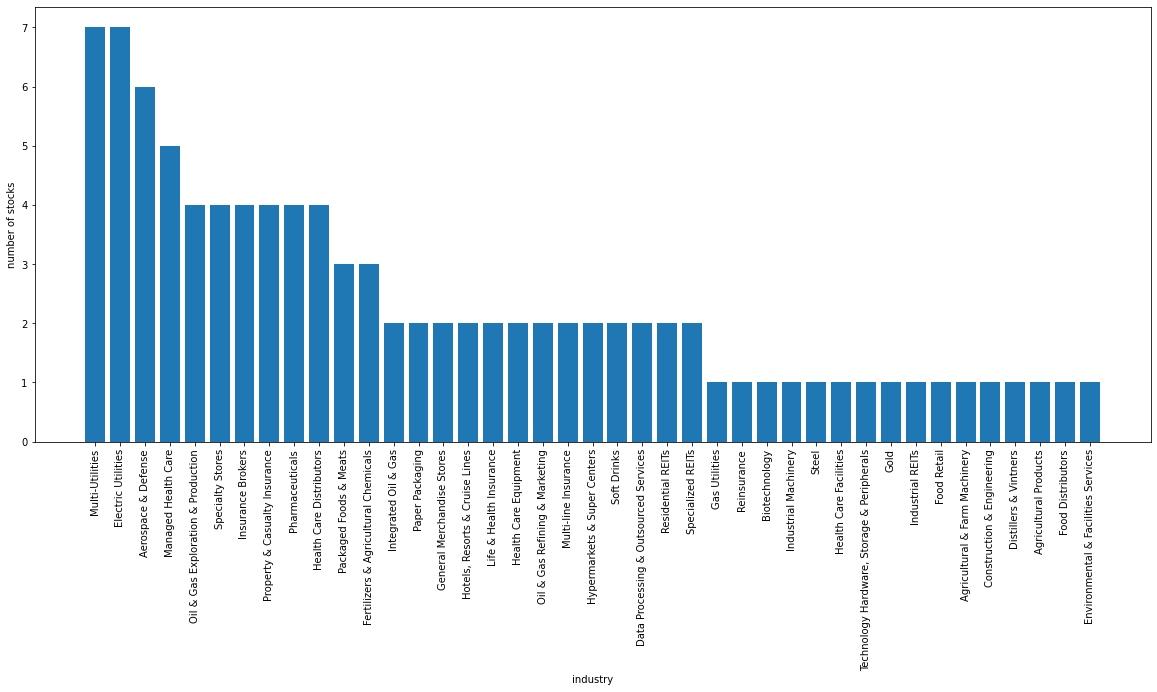

In [6]:
industry_value_counts = df[df["highest_day"] >= "2022-04-01"]["GICS Sub-Industry"].value_counts()
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(industry_value_counts.index, industry_value_counts.values)
ax.set_xticklabels(industry_value_counts.index, rotation=90)
ax.set_xlabel("industry")
ax.set_ylabel("number of stocks")
plt.show()